# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

In [2]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [3]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)


In [4]:
lc = Hopf(rho=1.0, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [5]:
y0 = torch.tensor([[1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
y0.shape

torch.Size([3, 2])

In [6]:
lc.f(t = 0, x = y0).shape

torch.Size([3, 2])

In [7]:
sol = odeint(func=lc.f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [8]:

sol.shape

torch.Size([100, 3, 2])

In [215]:
a = torch.arange(-2.0, 2.0, 0.25); b = torch.arange(-2, 2, 0.25)
ic = torch.cartesian_prod(a, b)


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


torch.Size([256, 2])

In [216]:
sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )


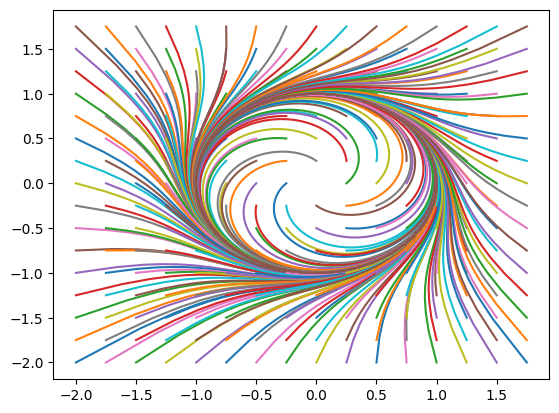

In [217]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

In [218]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [219]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 256, 2]) torch.Size([1, 200])


# Neural ODE - 

In [220]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [221]:
class Dynamic_Bif_NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE with time-varying latent variable. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
            self.r                  = None 
    
    def set_parameter(self, r):
        """Set the latent variable function that takes time and returns a float"""
        if not callable(r):
            raise TypeError(f"Expected a callable function, got {type(r)}")
        self.r = r
    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        r_tensor = torch.full((x.shape[0], 1), fill_value=self.r(t))
        input = torch.cat((x, r_tensor), dim=1)
        out = self.network(input) #(num_traj, spatial_dim+drivers)
        return out

In [222]:
model = NODE(input_dim=lc.system_dim, output_dim=lc.system_dim, depth=5, width=20, activation_func=nn.Tanh())  

In [223]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [224]:
num_epochs = 500
batch_size = 32
num_batches = 10

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(model, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/500 [00:00<07:04,  1.17it/s]

Epoch 0, Loss: 1.767386794090271


  4%|▍         | 21/500 [00:19<08:18,  1.04s/it]

Epoch 20, Loss: 0.6420255303382874


  8%|▊         | 41/500 [00:40<07:33,  1.01it/s]

Epoch 40, Loss: 0.5207604169845581


 12%|█▏        | 61/500 [00:59<06:24,  1.14it/s]

Epoch 60, Loss: 0.4626966714859009


 16%|█▌        | 81/500 [01:16<05:44,  1.22it/s]

Epoch 80, Loss: 0.40880492329597473


 20%|██        | 101/500 [01:33<05:41,  1.17it/s]

Epoch 100, Loss: 0.34367823600769043


 24%|██▍       | 121/500 [01:50<05:20,  1.18it/s]

Epoch 120, Loss: 0.2718087136745453


 28%|██▊       | 141/500 [02:08<05:08,  1.17it/s]

Epoch 140, Loss: 0.2218799740076065


 32%|███▏      | 161/500 [02:25<04:48,  1.18it/s]

Epoch 160, Loss: 0.17645490169525146


 36%|███▌      | 181/500 [02:42<04:42,  1.13it/s]

Epoch 180, Loss: 0.13448059558868408


 40%|████      | 201/500 [02:59<04:23,  1.14it/s]

Epoch 200, Loss: 0.09397383779287338


 44%|████▍     | 221/500 [03:17<04:03,  1.14it/s]

Epoch 220, Loss: 0.0600297674536705


 48%|████▊     | 241/500 [03:36<04:47,  1.11s/it]

Epoch 240, Loss: 0.039932895451784134


 52%|█████▏    | 261/500 [03:59<04:26,  1.11s/it]

Epoch 260, Loss: 0.03146464750170708


 56%|█████▌    | 281/500 [04:17<03:05,  1.18it/s]

Epoch 280, Loss: 0.02809661440551281


 60%|██████    | 301/500 [04:34<02:53,  1.15it/s]

Epoch 300, Loss: 0.026461536064743996


 64%|██████▍   | 321/500 [04:51<02:41,  1.11it/s]

Epoch 320, Loss: 0.025458838790655136


 68%|██████▊   | 341/500 [05:08<02:12,  1.20it/s]

Epoch 340, Loss: 0.024731216952204704


 72%|███████▏  | 361/500 [05:25<01:55,  1.21it/s]

Epoch 360, Loss: 0.02414737455546856


 76%|███████▌  | 381/500 [05:42<01:40,  1.18it/s]

Epoch 380, Loss: 0.023649442940950394


 80%|████████  | 401/500 [05:59<01:25,  1.16it/s]

Epoch 400, Loss: 0.02340739220380783


 84%|████████▍ | 421/500 [06:16<01:06,  1.19it/s]

Epoch 420, Loss: 0.02289123274385929


 88%|████████▊ | 441/500 [06:33<00:49,  1.20it/s]

Epoch 440, Loss: 0.022449741140007973


 92%|█████████▏| 461/500 [06:49<00:32,  1.22it/s]

Epoch 460, Loss: 0.02211163565516472


 96%|█████████▌| 481/500 [07:06<00:16,  1.13it/s]

Epoch 480, Loss: 0.02174380049109459


100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


In [86]:
# Analysis of Trained Model

Text(0.5, 0, 'Epochs')

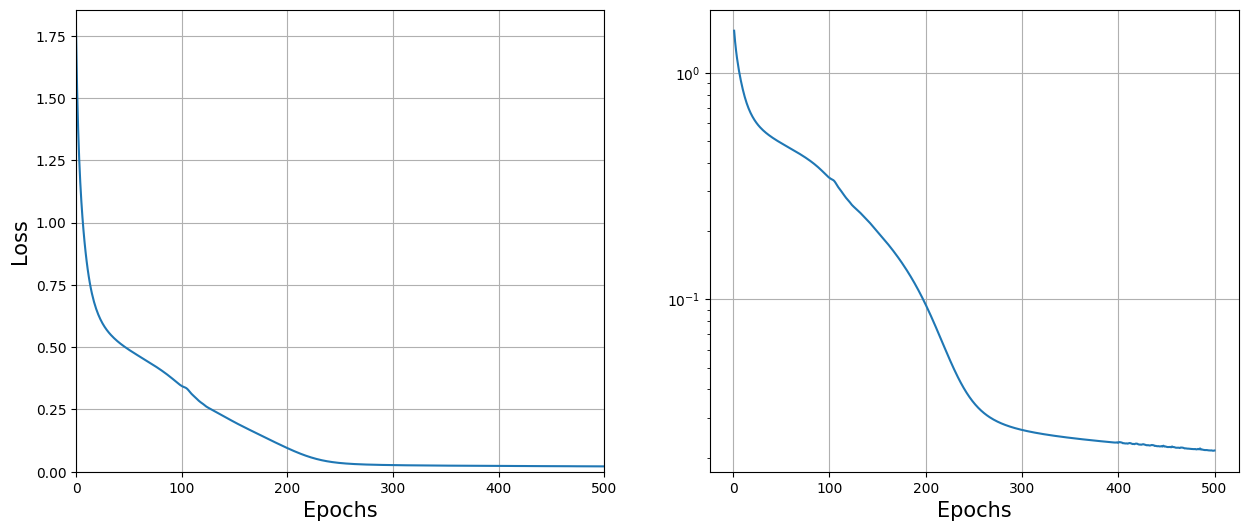

In [225]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [226]:
a = torch.linspace(-2, 2, 10)  # To initialize the random number generator
b = torch.linspace(-2, 2, 10)  # To initialize the random number generator

pts = torch.cartesian_prod(a, b)

In [227]:
t_Start_pred = 0; t_Final_pred = 2; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
node_data = odeint(model, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts.float(), t=t_eval_pred, method='rk4')

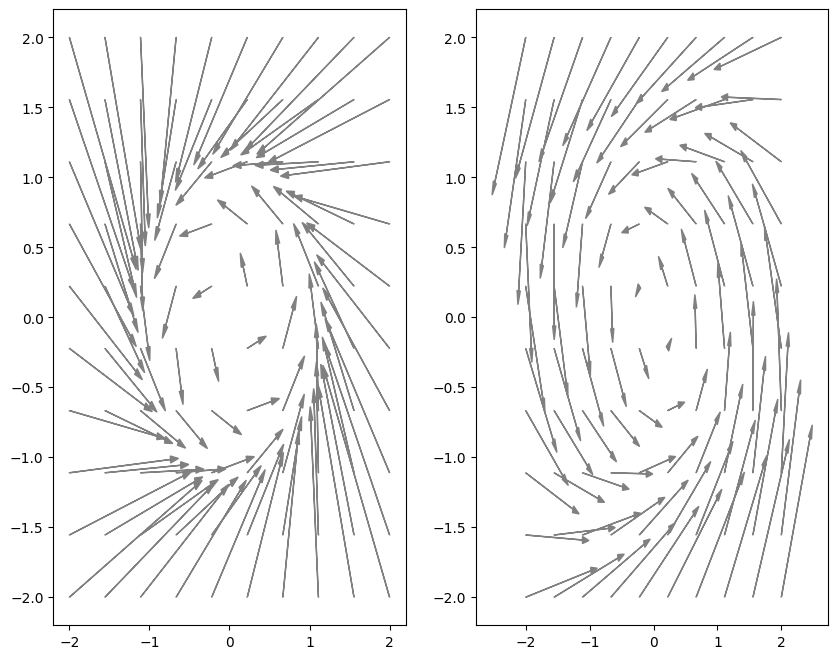

In [228]:
#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

In [230]:
a= torch.linspace(-1, 1, 10); 
init_pts = torch.cartesian_prod(a, a)

In [244]:
test_data_node = odeint(model, init_pts, torch.arange(t_span[0], 30, dt), method='rk4')

In [245]:
test_data_node.shape

torch.Size([600, 100, 2])

In [248]:
i = 0

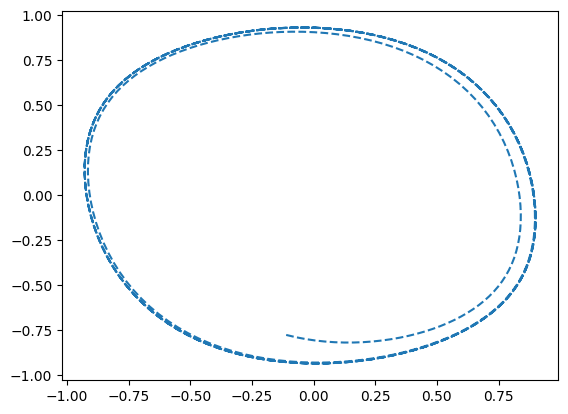

In [290]:

plt.plot(test_data_node[:, i, 0].detach().numpy(), test_data_node[:, i, 1].detach().numpy(), linestyle='--')
i = i + 1